# Hidden Markov Models (HMMs)

In [37]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt

# matplotlib configuration
import matplotlib as mpl
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["figure.figsize"] = (15, 5)
# retina display only (e.g. MacOS)
%config InlineBackend.figure_format = 'retina'

### 2-State (Closed $\rightleftarrows$ Open) HMM for an ion channel

Starting probability in each state:

In [38]:
p0 = np.array([0.5, 0.5])  # P(C), P(O)

Transition probabilities per time step:

In [39]:
trans = np.array([[0.95, 0.05],   # P(C->C), P(C->O)
                  [0.15, 0.85]])  # P(O->C), P(O->O)

Emission (i.e. ionic current) distributions for each state:

In [40]:
emis = [st.norm(0, 1), st.norm(5, 1)]  # closed, open current distributions

### HMM Simulation

In [41]:
def simulateHMM(p0, trans, emis, numSamples):
    numStates = len(p0)
    stateIds = np.arange(numStates, dtype=int)  # 0, 1, ..., numStates-1
    
    # preallocate simulation arrays
    stateSequence = np.zeros(numSamples, dtype=int)
    observationSequence = np.zeros(numSamples)
    
    # reset pseudo random number generator
    np.random.seed(0)
    
    # randomly assign starting state
    stateSequence[0] = np.random.choice(stateIds, p=p0)
    
    # randomly assign subsequent states based on the transition probabilities
    for t in range(1, numSamples):
        prevState = stateSequence[t-1]
        stateSequence[t] = np.random.choice(stateIds, p=trans[prevState,:])
    
    # randomly draw state observations from emission distributions
    for state in stateIds:
        stateMask = (stateSequence == state)
        observationSequence[stateMask] = emis[state].rvs(stateMask.sum())
    
    return stateSequence, observationSequence

In [42]:
stateSeq, observationSeq = simulateHMM(p0, trans, emis, 1000)

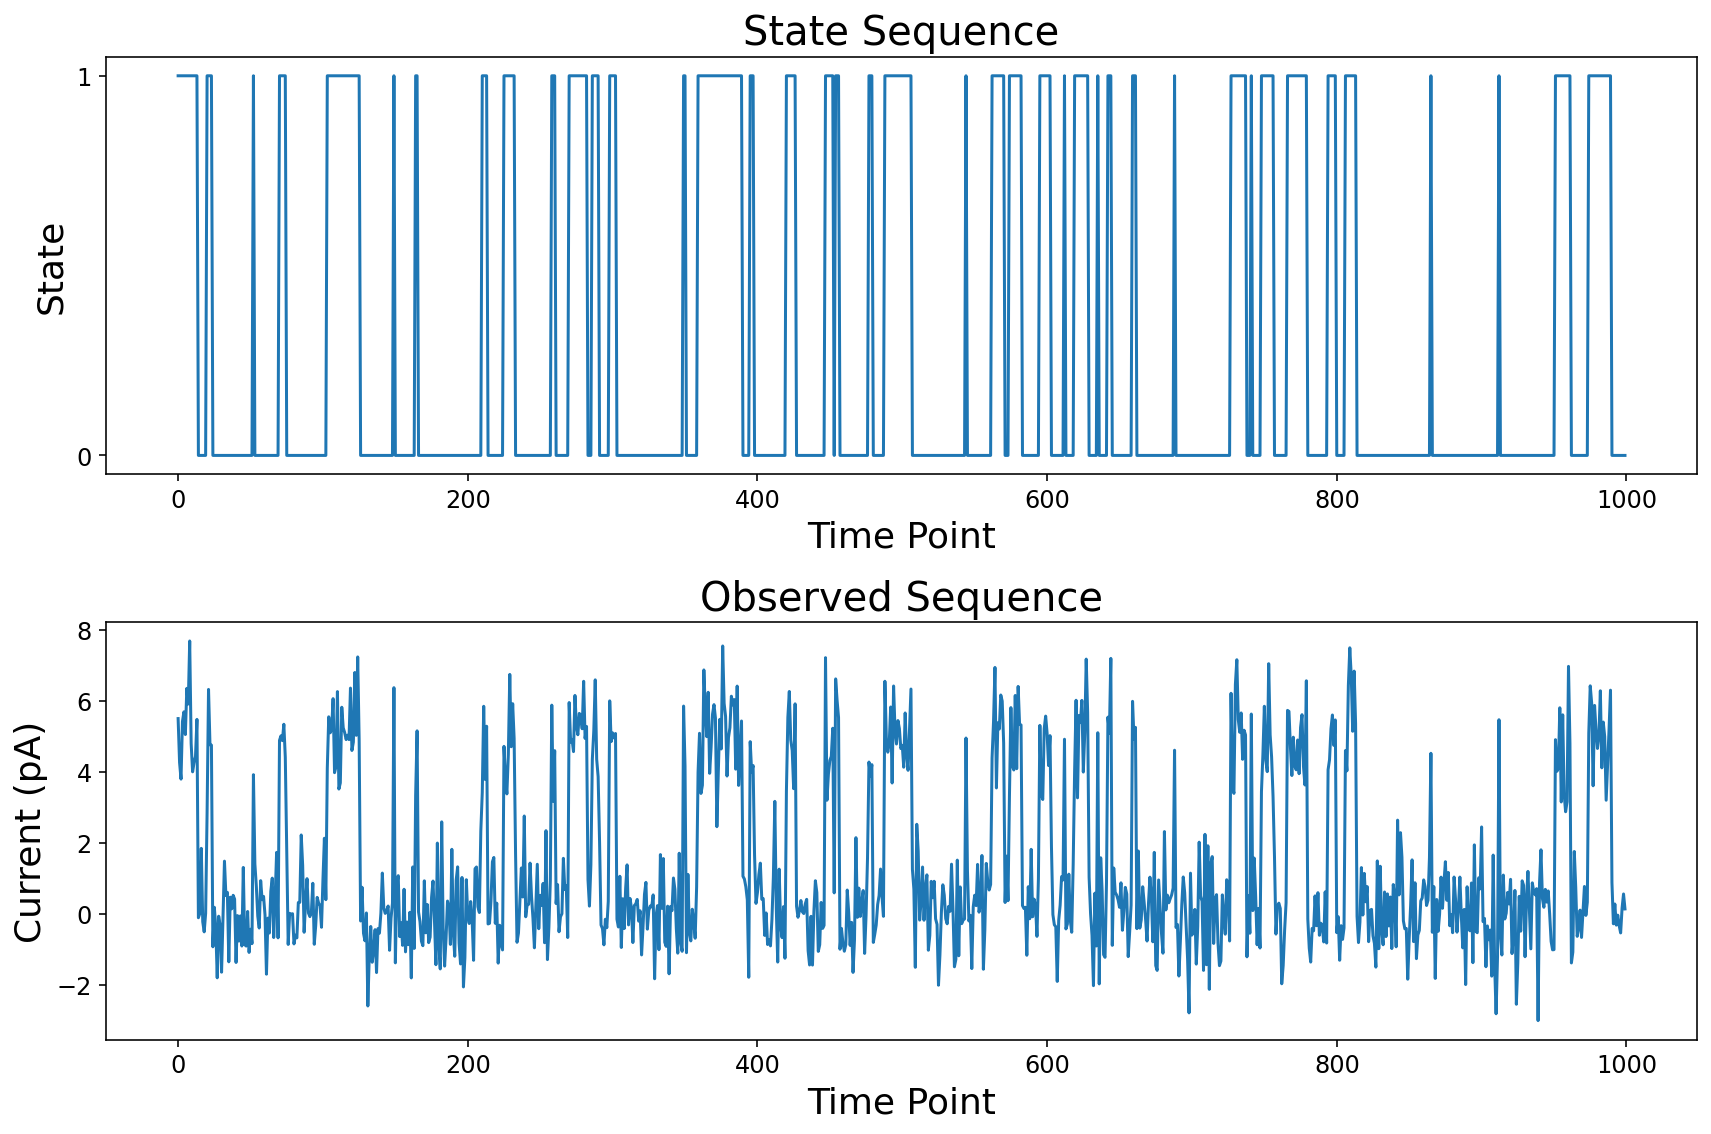

In [43]:
# state and observation sequences
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(stateSeq)
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence')
plt.subplot(2,1,2)
plt.plot(observationSeq)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Sequence')
plt.tight_layout();

### Threshold Idealization of Observations

In [44]:
threshold = 2.5
predictedStateSeq = np.zeros(observationSeq.shape, dtype=int)
predictedStateSeq[observationSeq < threshold] = 0
predictedStateSeq[observationSeq >= threshold] = 1

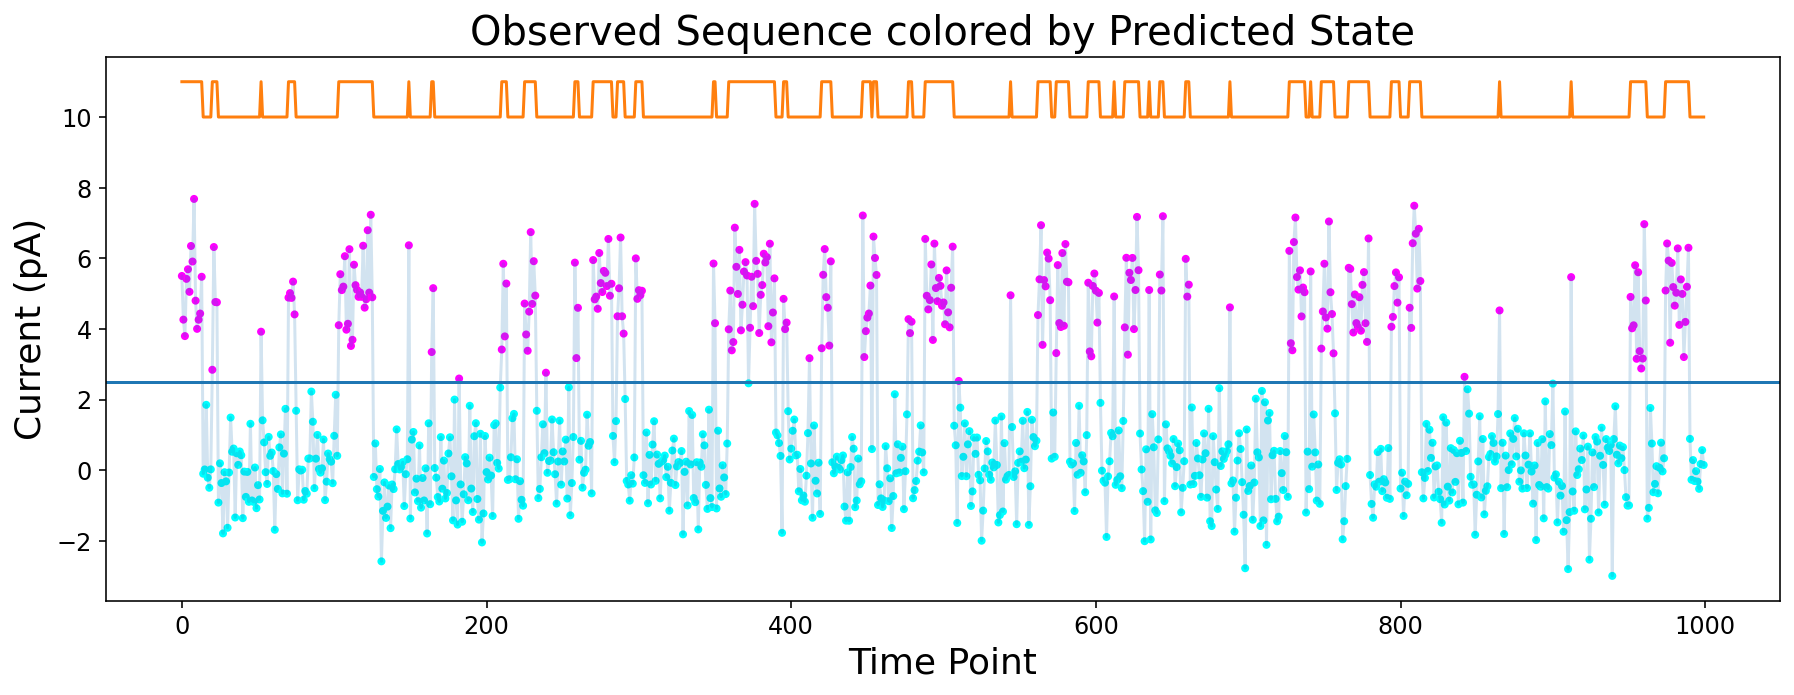

In [45]:
# thresholded state assignment
plt.plot(observationSeq, alpha=0.2)
plt.scatter(range(len(observationSeq)), observationSeq, marker='.', c=predictedStateSeq, cmap='cool')
plt.axhline(threshold)
plt.plot(stateSeq + 10)
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Observed Sequence colored by Predicted State');

How well did thresholding do? Can you think of a case where thresholding won't work well?

Other clustering methods such as GMMs, kmeans, etc. can also classify states by amplitude.

We'll explore some of these later in the semester.

## <font color=red> However, amplitude clustering can NOT:</font>

* distinguish states with identical or very similar emissions
* distinguish between a random large noise fluctuation and a transition

## <font color=blue>HMMs can do this.</font>

# Filtering and Missed Events

In [46]:
dt_ms = 0.1
fs_kHz = 1 / dt_ms
time_ms = np.arange(len(observationSeq)) * dt_ms
current_pA = observationSeq

In [47]:
from scipy import signal

lowpass2kHz = signal.firwin(301, 2, nyq=fs_kHz/2)
lowpass1kHz = signal.firwin(301, 1, nyq=fs_kHz/2)

filtered2kHz = np.convolve(current_pA, lowpass2kHz, 'same')
filtered1kHz = np.convolve(current_pA, lowpass1kHz, 'same')

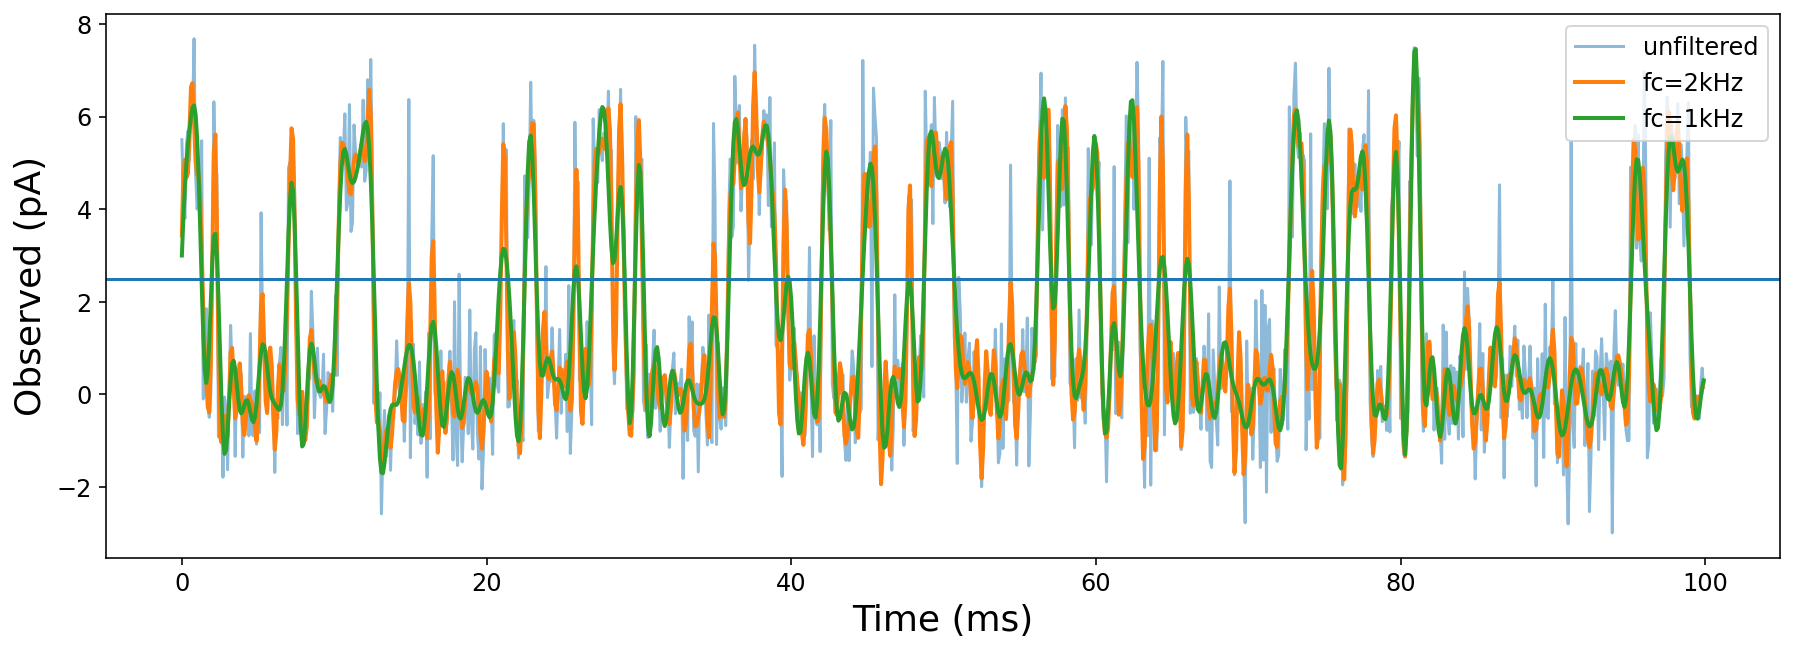

In [48]:
plt.plot(time_ms, current_pA, alpha=0.5, label='unfiltered')
plt.plot(time_ms, filtered2kHz, lw=2, label='fc=2kHz')
plt.plot(time_ms, filtered1kHz, lw=2, label='fc=1kHz')
plt.axhline(threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Observed (pA)');
plt.legend();

Examine the plot and see if you can think of a **pro** and a **con** of filtering.

### 3-State (Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized) HMM for an ion channel

Starting probability in each state:

In [49]:
p0 = np.array([1, 0, 0])  # P(C), P(O), P(D)

Transition probabilities per time step:

In [50]:
trans = np.array([[0.950, 0.050, 0.000],   # P(C->C), P(C->O), P(C->D)
                  [0.030, 0.950, 0.020],   # P(O->C), P(O->O), P(O->D)
                  [0.000, 0.004, 0.996]])  # P(D->C), P(D->O), P(D->D)

Emission (i.e. ionic current) distributions for each state:

In [51]:
emis = [st.norm(0, 1), st.norm(5, 1), st.norm(0, 1)]

Simulate some data for the HMM:

In [52]:
stateSeq, current_pA = simulateHMM(p0, trans, emis, 1000000)

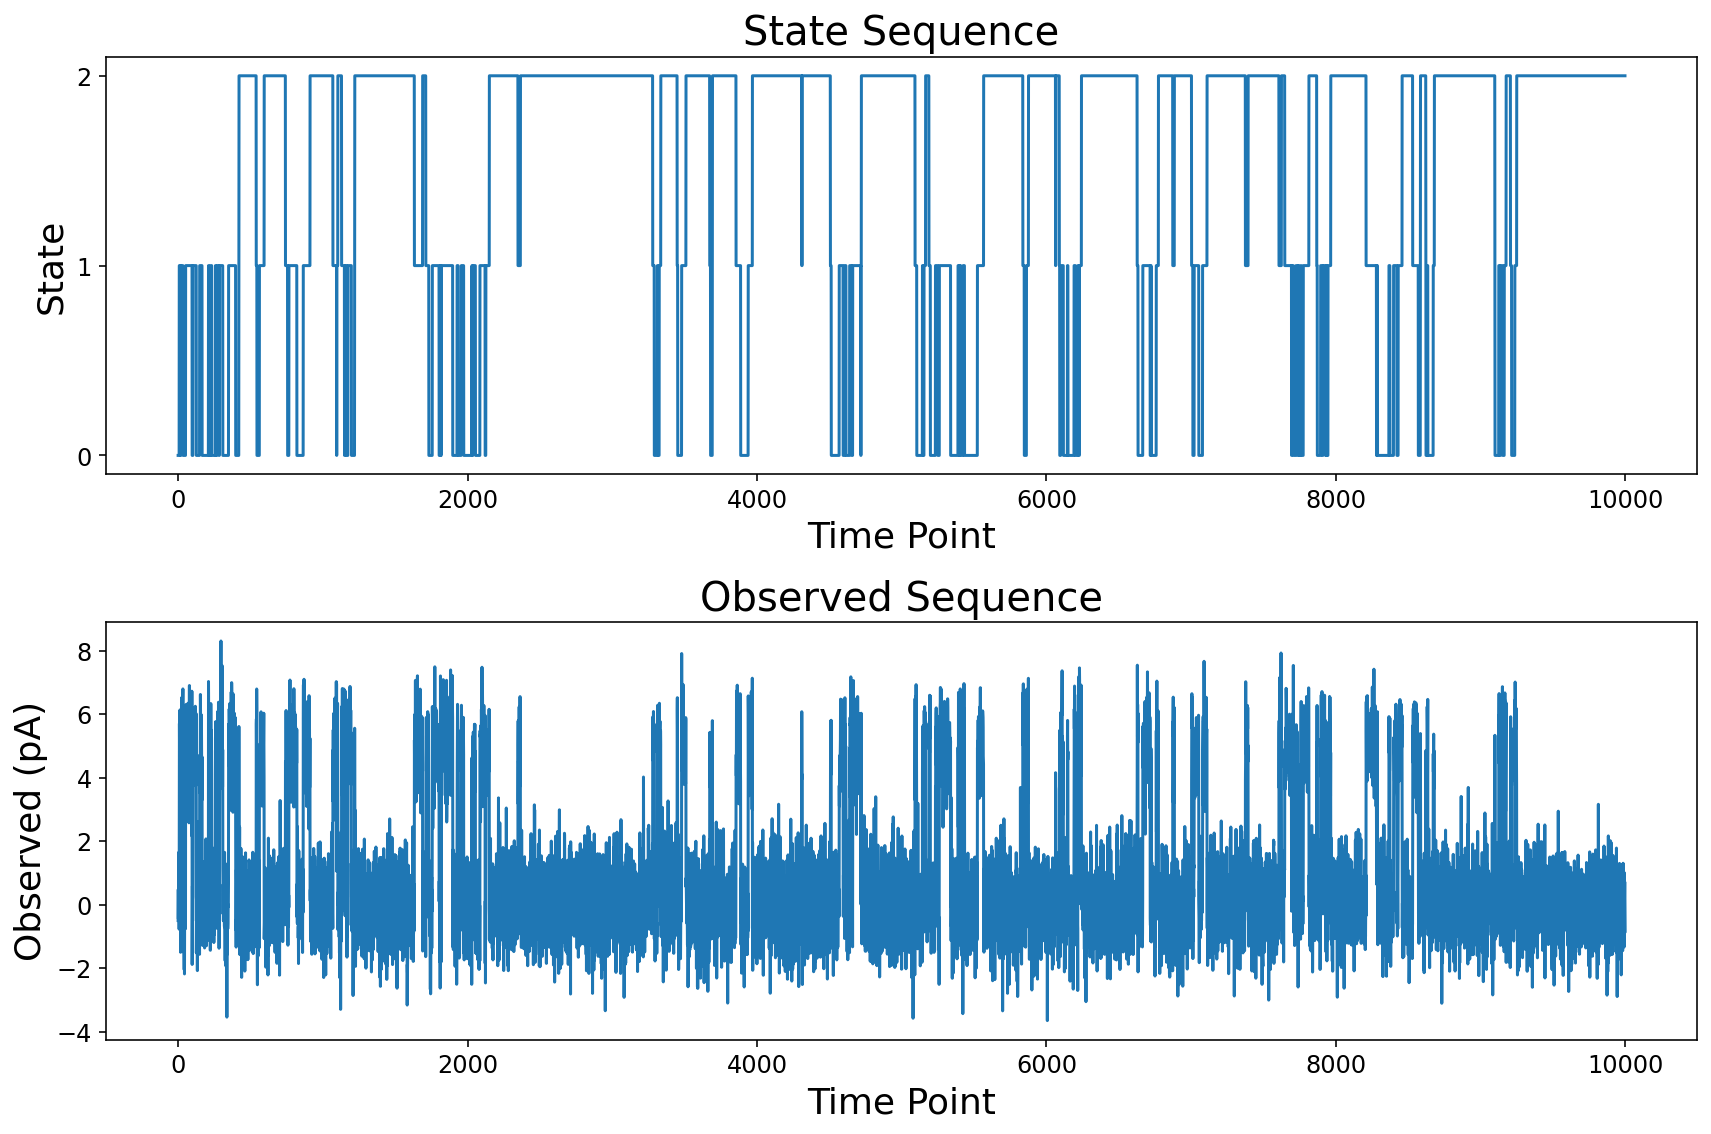

In [53]:
# state and observation sequences
n = 10000
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(stateSeq[:n])
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence')
plt.subplot(2,1,2)
plt.plot(current_pA[:n])
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence')
plt.tight_layout();

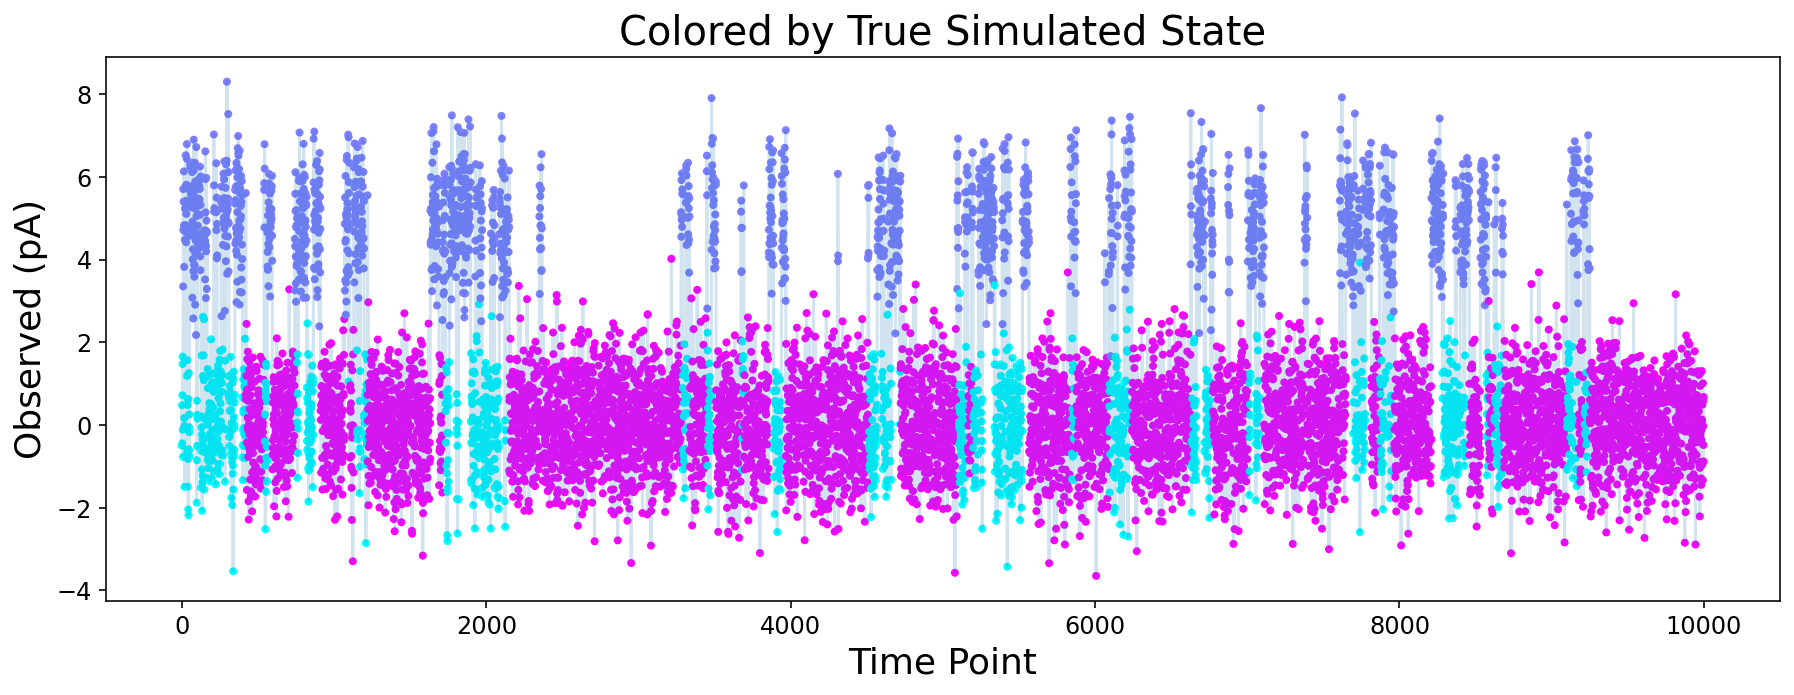

In [54]:
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=stateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by True Simulated State');

How might you distinguish between the closed and desensitized states?

### Dwell Time Distributions

Examination of these distributions can suggest how many states at each emission level you should include in your model.

In [55]:
dwelltimes = {}
for i in np.unique(stateSeq):
    dwelltimes[i] = []
for i, state in enumerate(stateSeq):
    if i > 0 and stateSeq[i-1] == state:
        dwelltimes[state][-1] += 1
    else:
        dwelltimes[state].append(1)

shutTimes = dwelltimes[0] + dwelltimes[2]
openTimes = dwelltimes[1]

dt_ms = 0.1
shutTimes_ms = np.array(shutTimes) * dt_ms
openTimes_ms = np.array(openTimes) * dt_ms

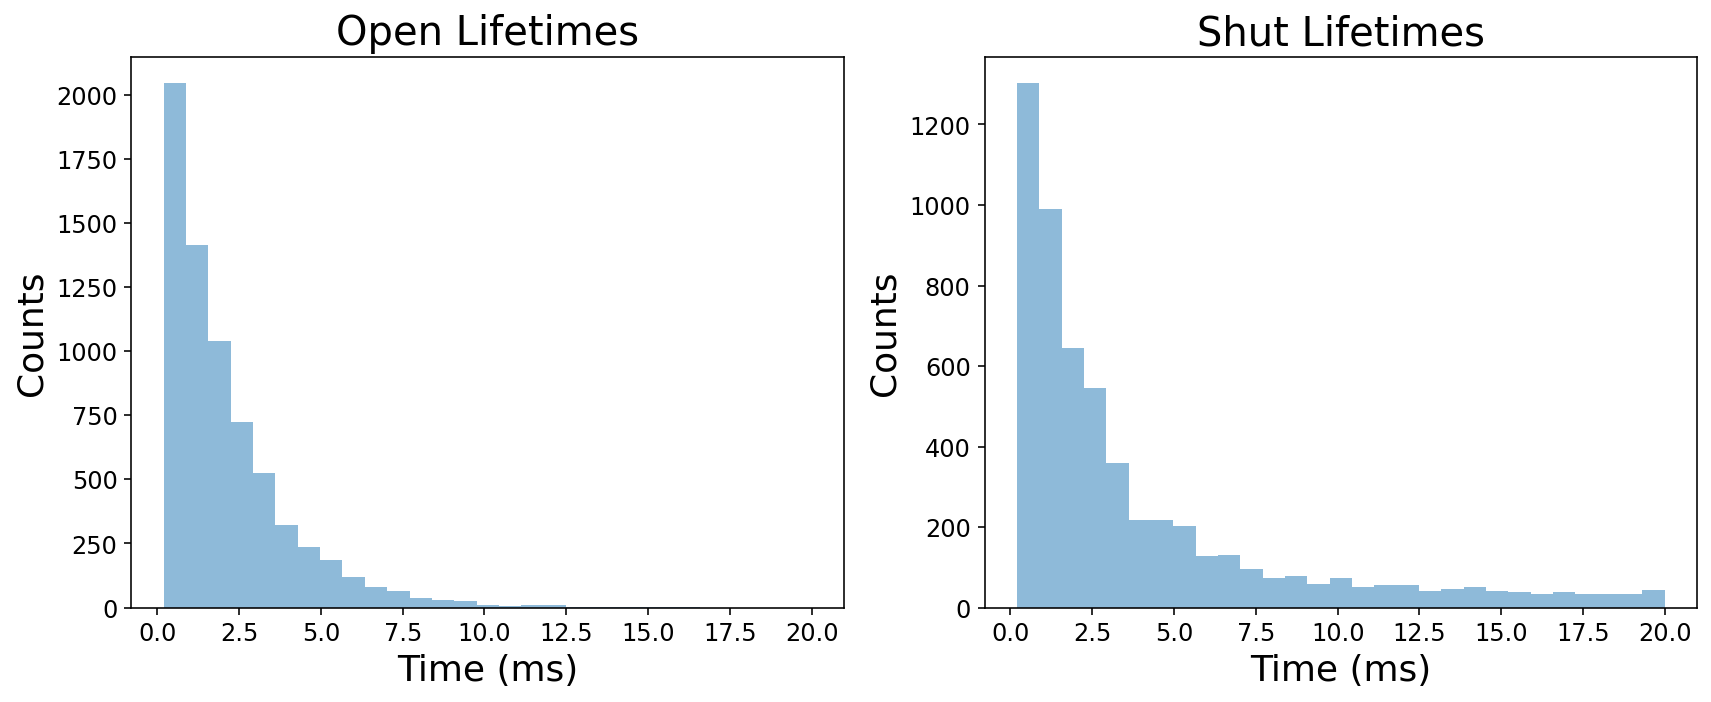

In [56]:
# dwell time histograms
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
binedges = np.linspace(0.2, 20, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Open Lifetimes')
plt.subplot(1, 2, 2)
binedges = np.linspace(0.2, 20, 30)
plt.hist(shutTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Shut Lifetimes')
plt.tight_layout();

Dwelltimes are often binned and plotted on a logscale.

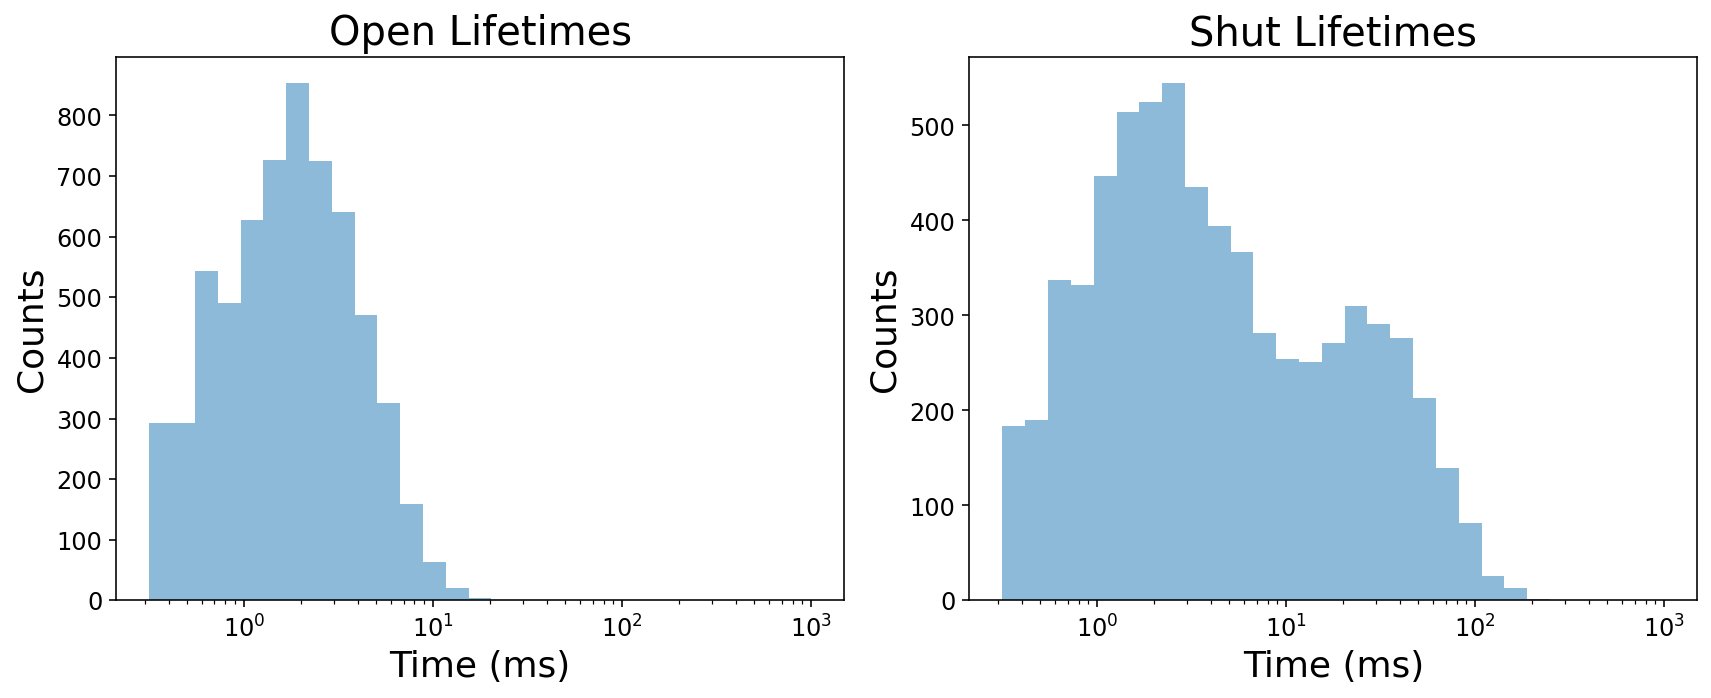

In [57]:
# dwell time histograms on logscale
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(openTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Open Lifetimes')
plt.xscale('log')
plt.subplot(1, 2, 2)
binedges = np.logspace(-0.5, 3, 30)
plt.hist(shutTimes_ms, binedges, alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Counts')
plt.title('Shut Lifetimes')
plt.xscale('log')
plt.tight_layout();

### Observations $\rightarrow$ HMM

`conda install pip`

`pip install pomegranate==0.14.3` <-- Version is important as latest version has some bugs!

In [58]:
import pomegranate as pom

### Postulate a HMM to explain the observed current sequence.

In [59]:
hmm = pom.HiddenMarkovModel()

In [60]:
# states
C = pom.State(pom.NormalDistribution(1, 0.8), name='Closed')
O = pom.State(pom.NormalDistribution(7, 1), name='Open')
D = pom.State(pom.NormalDistribution(0, 0.8), name='Desensitized')
hmm.add_states([C, O, D])

In [61]:
# starting probability in each state (MUST add to one)
hmm.add_transition(hmm.start, C, 0.9)
hmm.add_transition(hmm.start, O, 0.1)

In [62]:
# transition probabilites per time step between states
hmm.add_transition(C, C, 0.90)
hmm.add_transition(C, O, 0.10) # sum from C MUST add to one

hmm.add_transition(O, C, 0.05)
hmm.add_transition(O, O, 0.90)
hmm.add_transition(O, D, 0.05) # sum from O MUST add to one

hmm.add_transition(D, O, 0.05)
hmm.add_transition(D, D, 0.95) # sum from D MUST add to one

In [63]:
# we have to bake it before we can use it!
hmm.bake()

`hmm.states`

A list of dictionaries (one per state) with info about the HMM.

In [64]:
hmm.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             1.0,
             0.8
         ],
         "frozen" : false
     },
     "name" : "Closed",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             0.0,
             0.8
         ],
         "frozen" : false
     },
     "name" : "Desensitized",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "name" : "NormalDistribution",
         "parameters" : [
             7.0,
             1.0
         ],
         "frozen" : false
     },
     "name" : "Open",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution"

In [65]:
hmm.states[0]

{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "name" : "NormalDistribution",
        "parameters" : [
            1.0,
            0.8
        ],
        "frozen" : false
    },
    "name" : "Closed",
    "weight" : 1.0
}

In [66]:
hmm.states[0].name

'Closed'

In [67]:
# mean, standard deviation
hmm.states[0].distribution.parameters

[1.0, 0.8]

In [68]:
stateNames = [state.name for state in hmm.states]
stateNames

['Closed', 'Desensitized', 'Open', 'None-start', 'None-end']

!!! Beware, the order of the states may be changed when you bake the HMM.

Initial parameters. These are just the parameters we specified above.

The row/column order of the transition matrix corresponds to the state order.

In [69]:
hmm.dense_transition_matrix()

array([[0.9 , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.95, 0.05, 0.  , 0.  ],
       [0.05, 0.05, 0.9 , 0.  , 0.  ],
       [0.9 , 0.  , 0.1 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [208]:
stateNames

['Closed', 'Desensitized', 'Open', 'None-start', 'None-end']

In [202]:
import pandas as pd

def printModelParams(hmm):
    A = hmm.dense_transition_matrix()
    Af = pd.DataFrame(A, index=stateNames, columns=stateNames)
    Bf = pd.DataFrame([state.distribution.parameters for state in hmm.states[:-2]], 
             index=[state.name for state in hmm.states[:-2]], columns=['mean', 'std'])
    states = ["Closed", "Open", "Desensitized"]
    print('Starting state probabilities:')
    print('-----------------------------')
    print(Af.loc[["None-start"], states])
    print()
    print('Transition probabilities:')
    print('-------------------------')
    print(Af.loc[states, states])
    print()
    print('Emission distribution parameters:')
    print('---------------------------------')
    print(Bf.loc[states,:])

In [71]:
# initial model (our starting guess for all parameters)
printModelParams(hmm)

Starting state probabilities:
-----------------------------
            Closed  Open  Desensitized
None-start     0.9   0.1           0.0

Transition probabilities:
-------------------------
              Closed  Open  Desensitized
Closed          0.90  0.10          0.00
Open            0.05  0.90          0.05
Desensitized    0.00  0.05          0.95

Emission distribution parameters:
---------------------------------
              mean  std
Closed         1.0  0.8
Open           7.0  1.0
Desensitized   0.0  0.8


Probability that our initial postulated model explains our observations.

In [72]:
hmm.probability(current_pA)

0.0

In [73]:
hmm.probability(current_pA[:100])  # less points

1.2244402059695228e-124

In [74]:
hmm.log_probability(current_pA)

-1849395.916627575

In [75]:
initialLogProb = hmm.log_probability(current_pA)

### Optimize the HMM parameters to best explain our observations.

Baum-Welch is a widely used algorithm for optimizing the parameters of an HMM.

In [76]:
hmm.fit([current_pA], algorithm='baum-welch');

Optimized HMM parameters in Pandas tables.

In [77]:
# optimized model parameters
printModelParams(hmm)

Starting state probabilities:
-----------------------------
            Closed  Open  Desensitized
None-start     1.0   0.0           0.0

Transition probabilities:
-------------------------
                Closed      Open  Desensitized
Closed        0.951481  0.048519      0.000000
Open          0.029712  0.950658      0.019630
Desensitized  0.000000  0.003809      0.996191

Emission distribution parameters:
---------------------------------
                  mean       std
Closed        0.002189  1.002569
Open          4.998957  1.001764
Desensitized -0.000972  0.998294


Probability that our optimized model explains our observations.

In [78]:
finalLogProb = hmm.log_probability(current_pA)

initialLogProb, finalLogProb

(-1849395.916627575, -1485776.438042688)

In [79]:
finalLogProb > initialLogProb

True

### Use the optimized HMM to predict the state sequence underlying the observations.

In [80]:
predictedStateSeq = hmm.predict(current_pA)

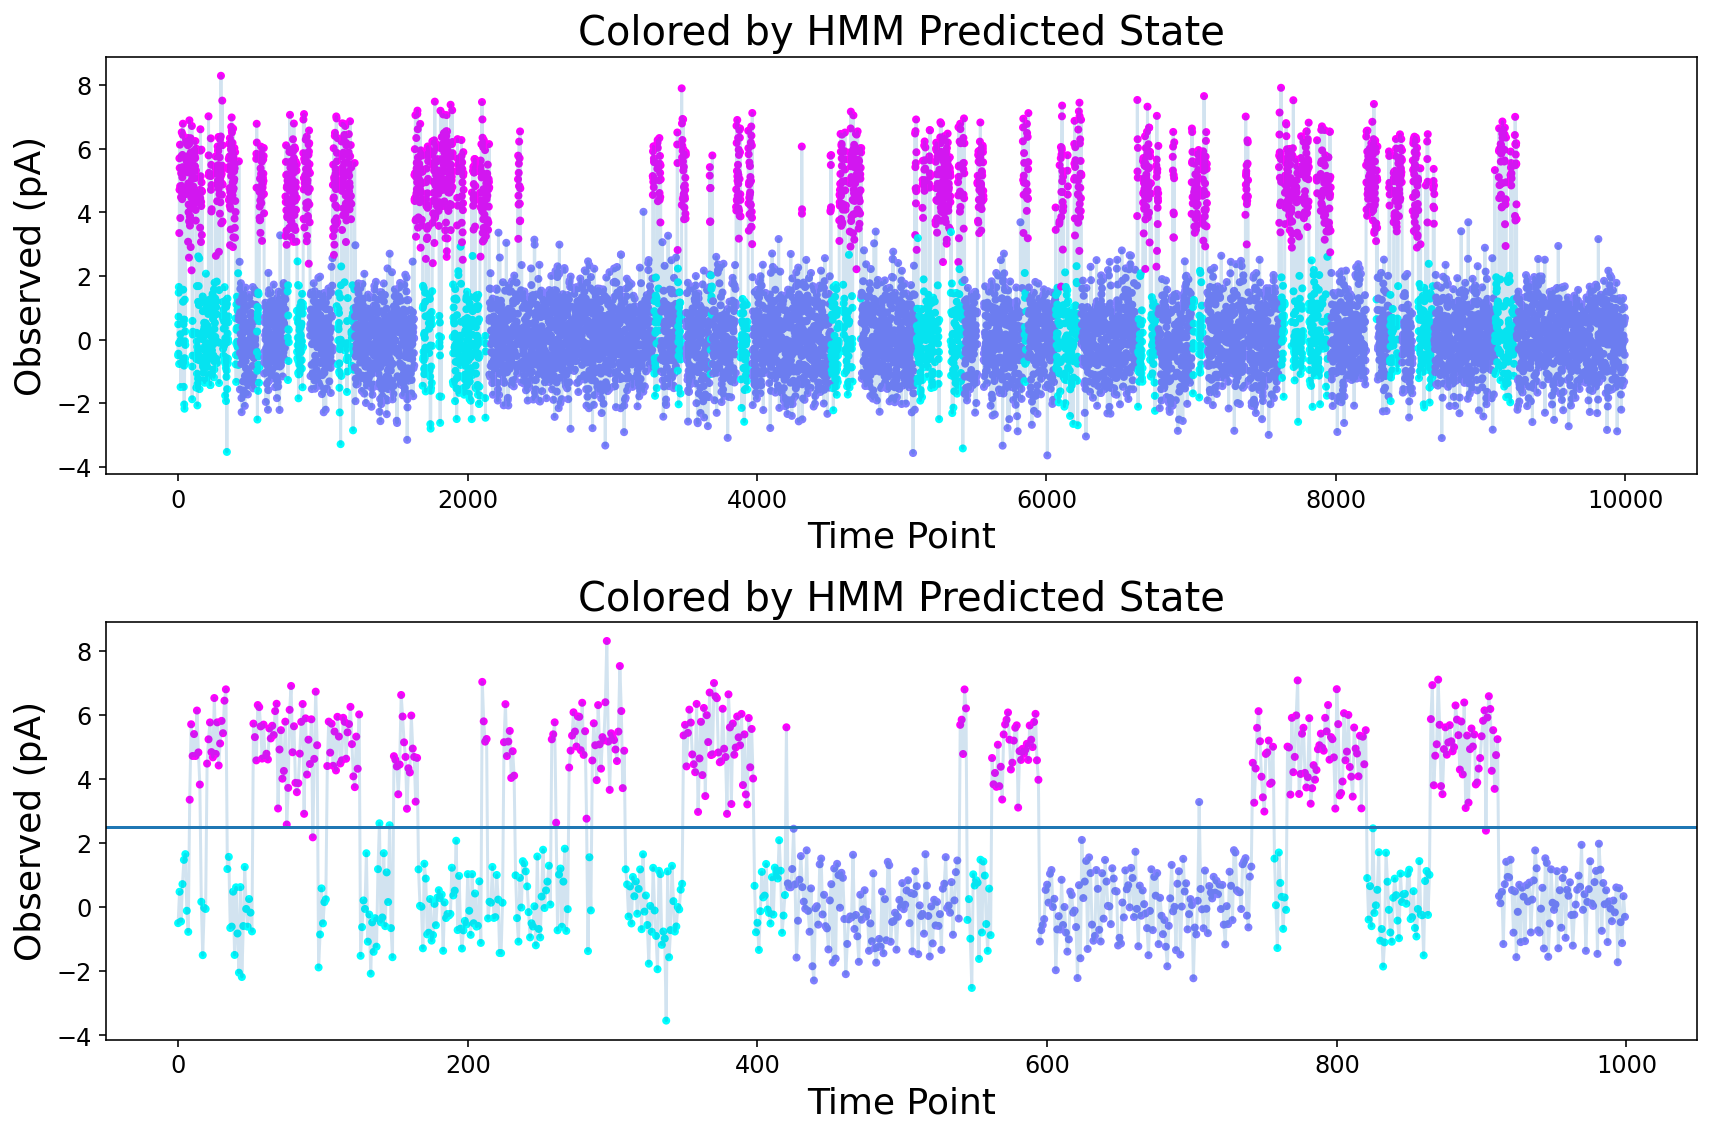

In [81]:
# predicted state sequence
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State')
plt.subplot(2, 1, 2)
n = 1000
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State')
plt.tight_layout();

Predicted state probabilities at each time step.

In [82]:
predictedStateProb = hmm.predict_proba(current_pA)
predictedStateProb.shape

(1000000, 3)

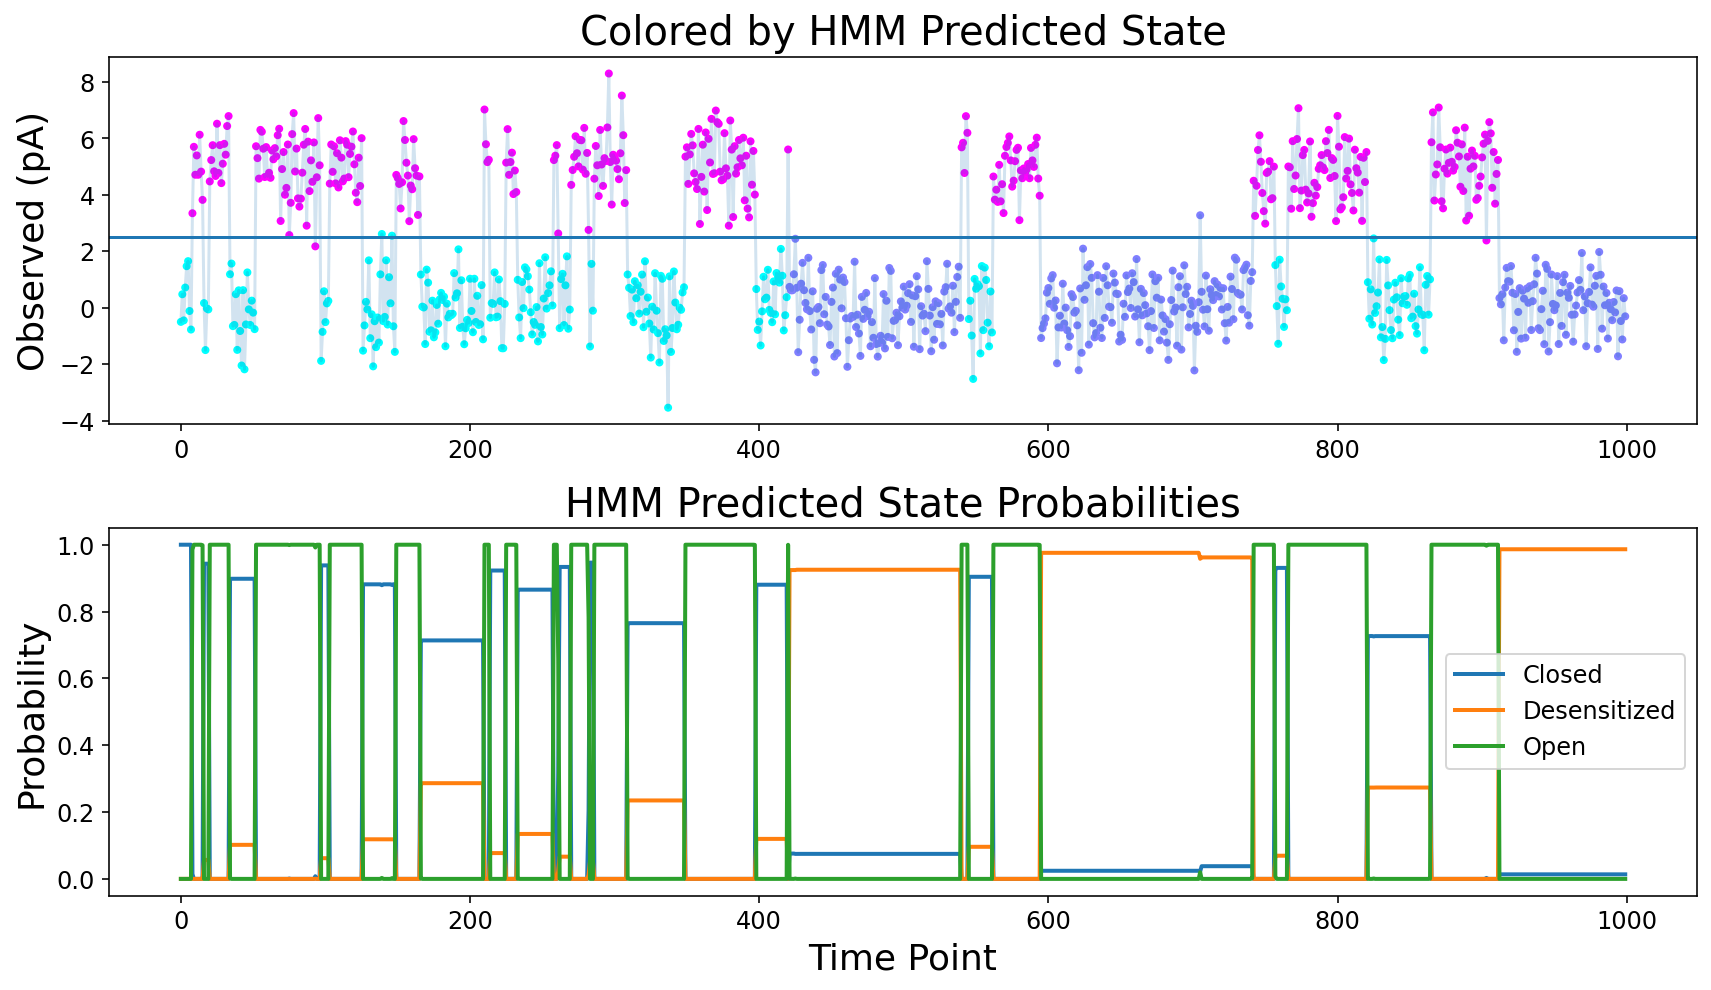

In [210]:
# predicted state probabilities
plt.figure(figsize=(12,7))
plt.subplot(2, 1, 1)
n = 1000
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
#plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State')
plt.subplot(2, 1, 2)
n = 1000
plt.plot(predictedStateProb[:n], lw=2)
plt.xlabel('Time Point')
plt.ylabel('Probability')
plt.title('HMM Predicted State Probabilities')
plt.legend(stateNames[:3])
plt.tight_layout();

# <font color=darkred> Exercise Part 1</font>

1. Using pomegranate build a model with 2-4 states whose emitted observations come from normal distributions and which are connected by up to 6 possible allowed transitions. You choose exactly how many states between 2 and 4, what the emission distribution parameters are for each state, and what the transition probabilites are between states. Please make the states distinct from each other in some way, either in emission or transition rate, but not necessarily both. Also make the probability of staying in each state per time step at least 0.5, otherwise their lifetime will be too close to the sample frequency.

2. Simulate a sequence of 100,000 observations using your model.
    
3. Make two plots showing your simulated noisy sequence - one plot showing the full sequence, and another plot zoomed in on the x-axis to clearly show a handful of simulated events (up to you, but maybe ~1000 pts).

# <font color=darkred> Exercise Part 2</font>

In a group, choose one person's simulated data. That person will share their screen to show their simulated data. **!!! BUT MAKE SURE YOU DON'T SHOW ANY OF THE PARAMETERS THAT WENT INTO THE SIMULATION !!!**.

The rest of the group's job is to try and come up with an HMM that describes the data. Since you don't know any of the underlying model parameters (**the person who simulated the data will NOT tell anyone how many states, the transition probabilities per time step, nor the state emissions**), you're going to have to develop a model from scratch given only the final noisy sequence. See if you can come up with a guess for how many states there are and how they might be connected.

The rest of the group will then direct the person sharing their simulated data to build and optimize a postulated HMM to explain the simulation. At the end, the person who simulated the data will tell you how close your final model is to the model they actually used for the simulation.
    
### How close did you come to the model used for the simulation?

# Exercise

Look at the observed data sequence below.

1. Postulate an HMM (i.e., states and transitions) that might explain this data.
2. Use pomegranate to optimize the HMM parameters for the observed seqeunce.
3. Visualize the most likely hidden state seqeunce. 

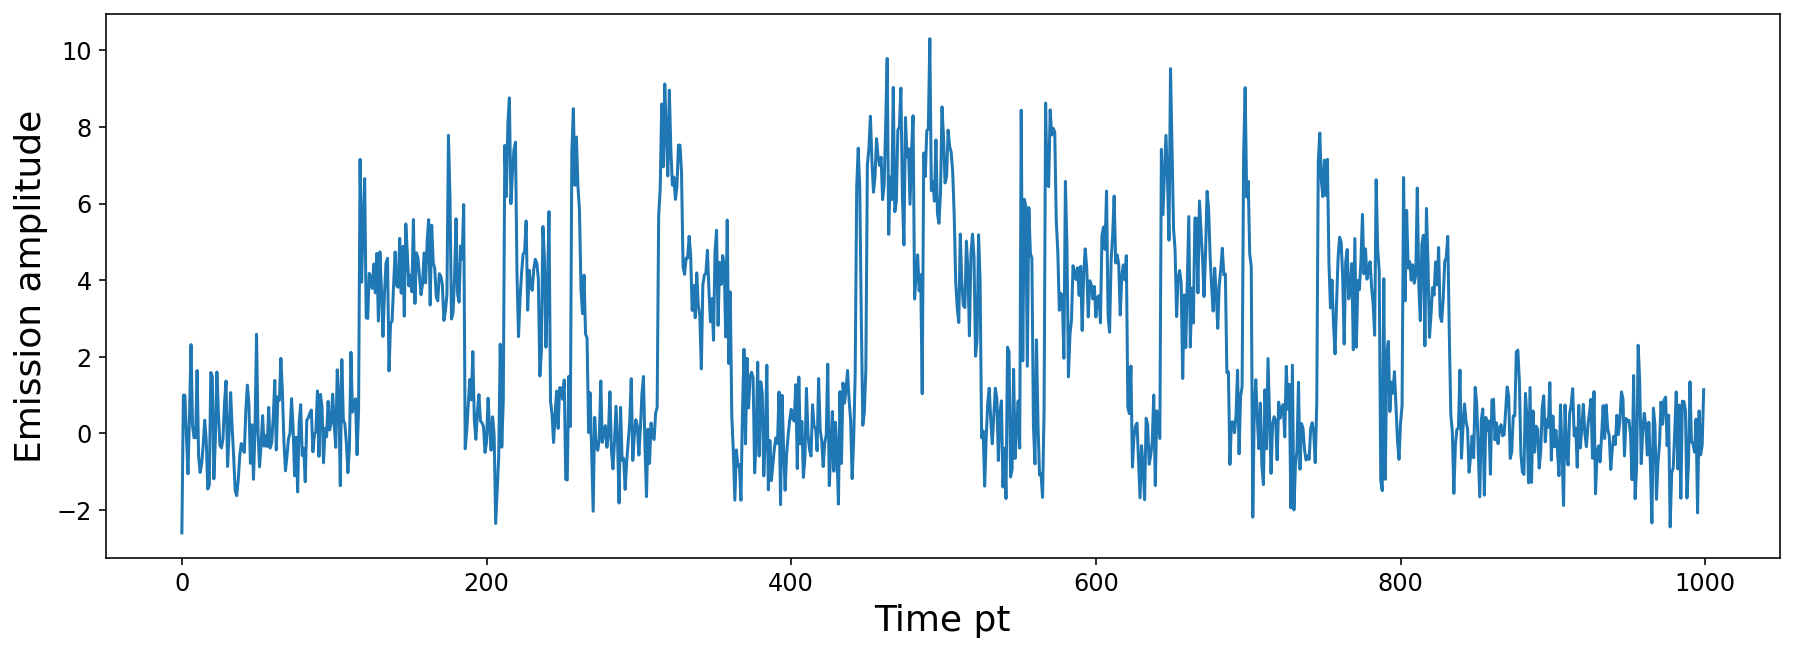

In [218]:
data_seq = np.load('observation_sequence.npy')

plt.plot(data_seq[:1000])
plt.xlabel('Time pt')
plt.ylabel('Emission amplitude');

In [ ]:
# create the model
hmm = ...

# add states
...

# starting probabilities
...

# transition probabilities
...

hmm.bake()

# optimize the model for the observed data seqeunce
...

# get the most likely hidden state sequence
state_seq = ...

# visualize the hidden state sequence for the first n data points
n = 1000
plt.plot(data_seq[:n], alpha=0.2)
plt.scatter(range(n), data_seq[:n], marker='.', c=state_seq[:n], cmap='cool')
plt.xlabel('Time pt')
plt.ylabel('Emission amplitude')
plt.title('Most likely hidden state sequence');

### Comparing multiple models

`hmmCO`: Closed $\rightleftarrows$ Open

`hmmCCO`: Closed1 $\rightleftarrows$ Closed2 $\rightleftarrows$ Open

`hmmCOD`: Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized

`hmm0COD`: Open1 $\rightleftarrows$ Closed $\rightleftarrows$ Open2 $\rightleftarrows$ Desensitized

`hmmCO`: Closed $\rightleftarrows$ Open

In [150]:
hmmCO = pom.HiddenMarkovModel()

# states
C = pom.State(pom.NormalDistribution(0, 1), name='Closed')
O = pom.State(pom.NormalDistribution(5, 1), name='Open')
hmmCO.add_states([C, O])

# starting probability in each state
hmmCO.add_transition(hmmCO.start, C, 0.9)
hmmCO.add_transition(hmmCO.start, O, 0.1)

# transition probabilites per time step between states
hmmCO.add_transition(C, C, 0.95)
hmmCO.add_transition(C, O, 0.05)

hmmCO.add_transition(O, C, 0.05)
hmmCO.add_transition(O, O, 0.95)

# we have to bake it before we can use it!
hmmCO.bake()

`hmmCCO`: Closed1 $\rightleftarrows$ Closed2 $\rightleftarrows$ Open

In [151]:
hmmCCO = pom.HiddenMarkovModel()

# states
C1 = pom.State(pom.NormalDistribution(0, 1), name='Closed1')
C2 = pom.State(pom.NormalDistribution(0, 1), name='Closed2')
O = pom.State(pom.NormalDistribution(5, 1), name='Open')
hmmCCO.add_states([C1, C2, O])

# starting probability in each state
hmmCCO.add_transition(hmmCCO.start, C1, 0.45)
hmmCCO.add_transition(hmmCCO.start, C2, 0.45)
hmmCCO.add_transition(hmmCCO.start, O, 0.1)

# transition probabilites per time step between states
hmmCCO.add_transition(C1, C1, 0.95)
hmmCCO.add_transition(C1, C2, 0.05)

hmmCCO.add_transition(C2, C1, 0.05)
hmmCCO.add_transition(C2, C2, 0.90)
hmmCCO.add_transition(C2, O, 0.05)

hmmCCO.add_transition(O, C2, 0.05)
hmmCCO.add_transition(O, O, 0.95)

# we have to bake it before we can use it!
hmmCCO.bake()

`hmmCOD`: Closed $\rightleftarrows$ Open $\rightleftarrows$ Desensitized

In [160]:
hmmCOD = pom.HiddenMarkovModel()

# states
C = pom.State(pom.NormalDistribution(0, 1), name='Closed')
O = pom.State(pom.NormalDistribution(5, 1), name='Open')
D = pom.State(pom.NormalDistribution(0, 1), name='Desensitized')
hmmCOD.add_states([C, O, D])

# starting probability in each state
hmmCOD.add_transition(hmmCOD.start, C, 0.9)
hmmCOD.add_transition(hmmCOD.start, O, 0.1)

# transition probabilites per time step between states
hmmCOD.add_transition(C, C, 0.95)
hmmCOD.add_transition(C, O, 0.05)

hmmCOD.add_transition(O, C, 0.05)
hmmCOD.add_transition(O, O, 0.90)
hmmCOD.add_transition(O, D, 0.05)

hmmCOD.add_transition(D, O, 0.05)
hmmCOD.add_transition(D, D, 0.95)

# we have to bake it before we can use it!
hmmCOD.bake()

`hmm0COD`: Open1 $\rightleftarrows$ Closed $\rightleftarrows$ Open2 $\rightleftarrows$ Desensitized

In [168]:
hmmOCOD = pom.HiddenMarkovModel()

# states
O1 = pom.State(pom.NormalDistribution(5, 1), name='Open1')
C = pom.State(pom.NormalDistribution(0, 1), name='Closed')
O2 = pom.State(pom.NormalDistribution(5, 1), name='Open2')
D = pom.State(pom.NormalDistribution(0, 1), name='Desensitized')
hmmOCOD.add_states([O1, C, O2, D])

# starting probability in each state
hmmOCOD.add_transition(hmmOCOD.start, C, 0.9)
hmmOCOD.add_transition(hmmOCOD.start, O1, 0.05)
hmmOCOD.add_transition(hmmOCOD.start, O2, 0.05)

# transition probabilites per time step between states
hmmOCOD.add_transition(O1, O1, 0.95)
hmmOCOD.add_transition(O1, C, 0.05)

hmmOCOD.add_transition(C, O1, 0.05)
hmmOCOD.add_transition(C, C, 0.95)
hmmOCOD.add_transition(C, O2, 0.05)

hmmOCOD.add_transition(O2, C, 0.05)
hmmOCOD.add_transition(O2, O2, 0.90)
hmmOCOD.add_transition(O2, D, 0.05)

hmmOCOD.add_transition(D, O2, 0.05)
hmmOCOD.add_transition(D, D, 0.95)

# we have to bake it before we can use it!
hmmOCOD.bake()

Optimize all models for our ion channel current recording.

Note: The Viterbi algorithm is faster than Baum-Welch as it uses only the most likely sequence instead of summing over all possible sequences.

In [153]:
hmmCO.fit([current_pA], algorithm='baum-welch');

In [154]:
hmmCCO.fit([current_pA], algorithm='baum-welch');

In [161]:
hmmCOD.fit([current_pA], algorithm='baum-welch');

In [169]:
hmmOCOD.fit([current_pA], algorithm='baum-welch');

In [206]:
def printModelParams2(hmm):
    states = [state.name for state in hmm.states]
    A = hmm.dense_transition_matrix()
    Af = pd.DataFrame(A, index=states, columns=states)
    Bf = pd.DataFrame([state.distribution.parameters for state in hmm.states[:-2]], 
             index=states[:-2])
    print('Transition probabilities:')
    print('-------------------------')
    print(Af)
    print()
    print('Emission distribution parameters:')
    print('---------------------------------')
    print(Bf)

In [207]:
printModelParams2(hmmOCOD)

Transition probabilities:
-------------------------
                Closed  Desensitized     Open1     Open2  None-start  None-end
Closed        0.951427      0.000000  0.000666  0.047907         0.0       0.0
Desensitized  0.000000      0.996189  0.000000  0.003811         0.0       0.0
Open1         0.093208      0.000000  0.906792  0.000000         0.0       0.0
Open2         0.029412      0.019735  0.000000  0.950853         0.0       0.0
None-start    1.000000      0.000000  0.000000  0.000000         0.0       0.0
None-end      0.000000      0.000000  0.000000  0.000000         0.0       0.0

Emission distribution parameters:
---------------------------------
                     0         1
Closed        0.002247  1.002557
Desensitized -0.000977  0.998298
Open1         5.326638  0.821962
Open2         4.997518  1.002251


Get the most likely state sequence according to each model (e.g. Viterbi algorithm).

In [170]:
predictedStateSeq_CO = hmmCO.predict(current_pA)
predictedStateSeq_CCO = hmmCCO.predict(current_pA)
predictedStateSeq_COD = hmmCOD.predict(current_pA)
predictedStateSeq_OCOD = hmmOCOD.predict(current_pA)

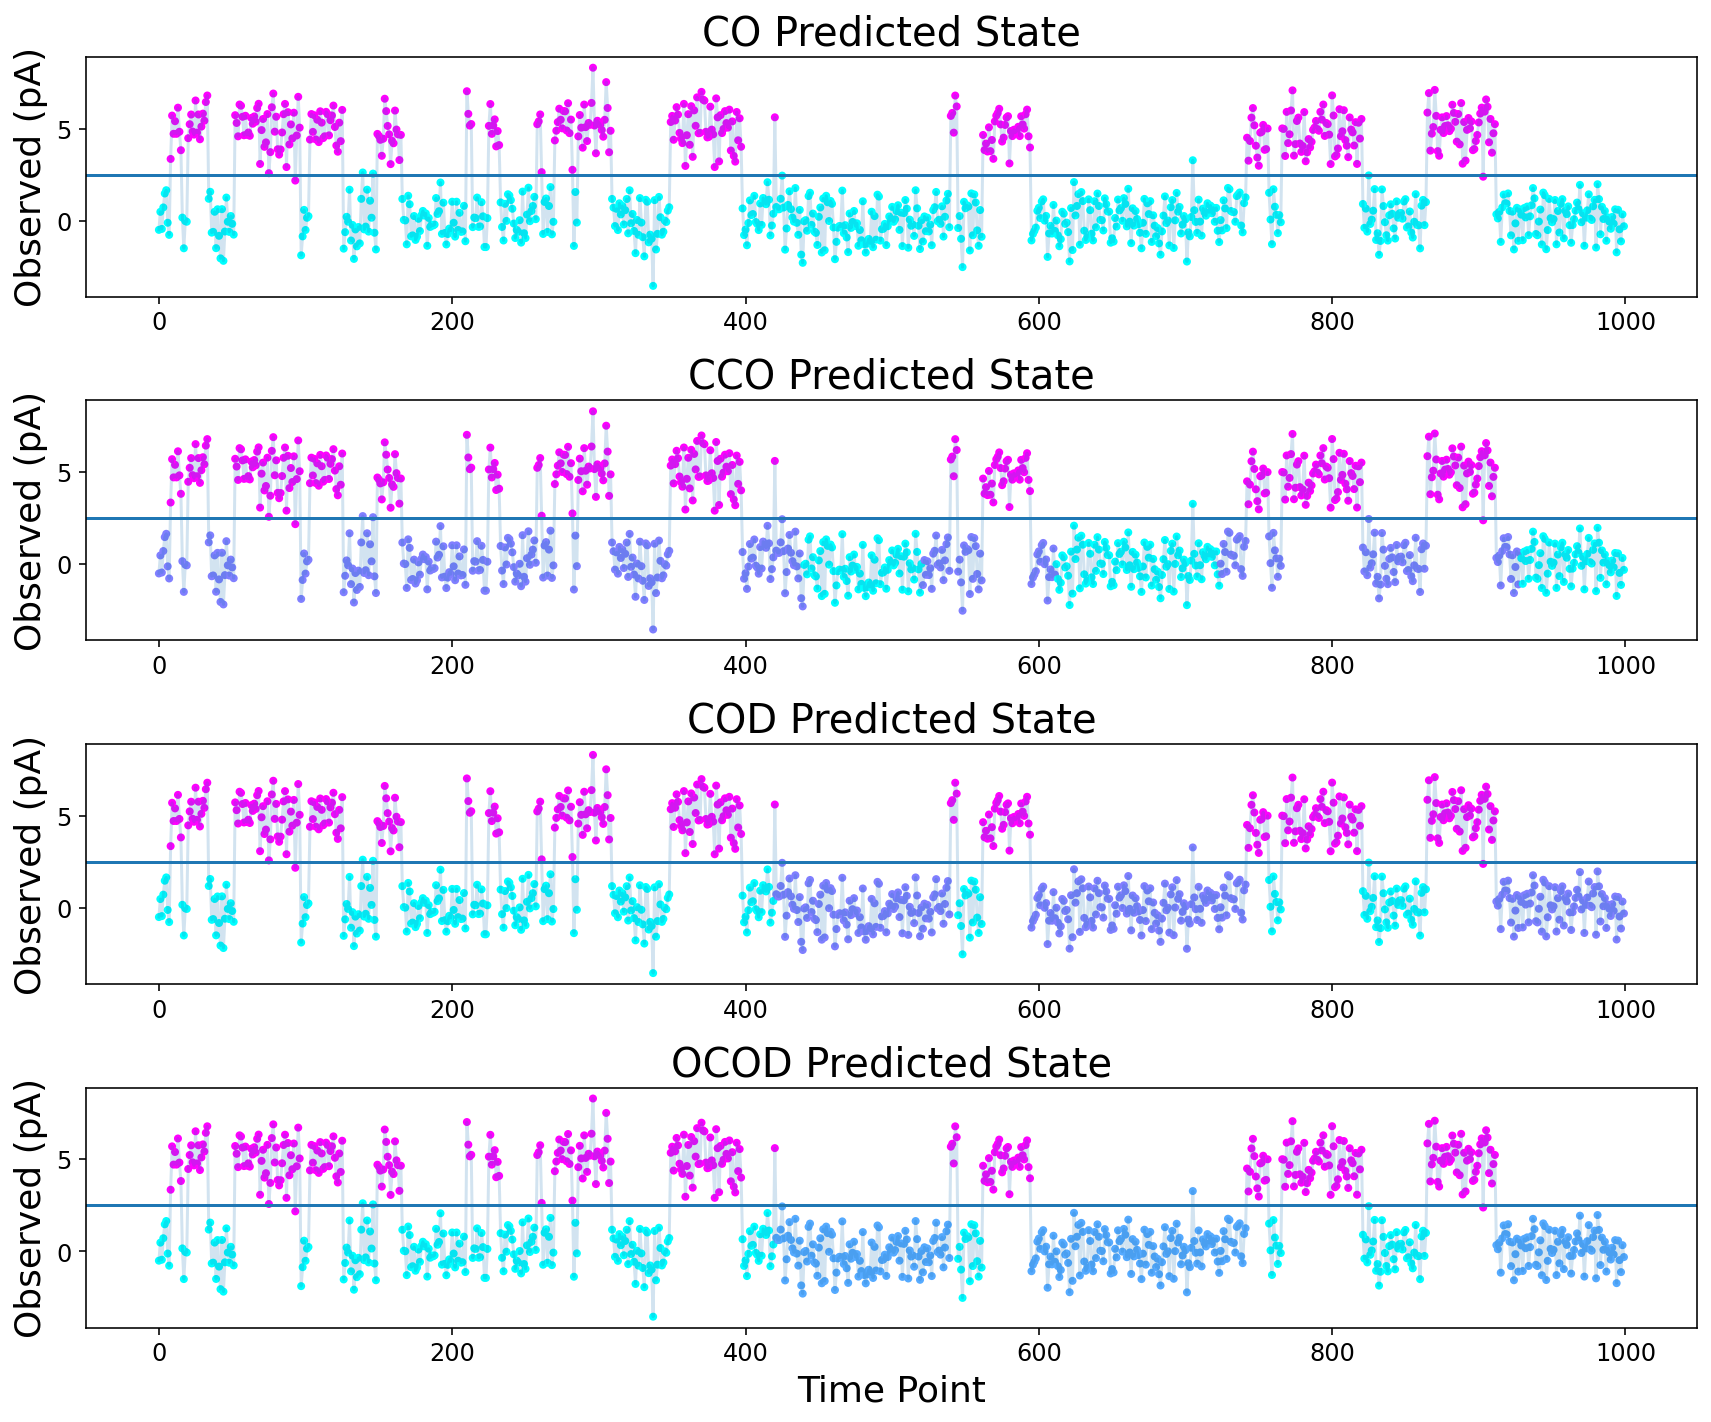

In [173]:
# predicted state sequence
plt.figure(figsize=(12,10))
n = 1000
plt.subplot(4, 1, 1)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq_CO[:n], cmap='cool')
#plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('CO Predicted State')
plt.subplot(4, 1, 2)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq_CCO[:n], cmap='cool')
#plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('CCO Predicted State')
plt.subplot(4, 1, 3)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq_COD[:n], cmap='cool')
#plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('COD Predicted State')
plt.subplot(4, 1, 4)
plt.plot(current_pA[:n], alpha=0.2)
plt.axhline(2.5)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq_OCOD[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('OCOD Predicted State')
plt.tight_layout();

What is the (log)likelihood that each model describes the current recording?

In [198]:
LL_CO = hmmCO.log_probability(current_pA)
LL_CCO = hmmCCO.log_probability(current_pA)
LL_COD = hmmCOD.log_probability(current_pA)
LL_OCOD = hmmOCOD.log_probability(current_pA)

LL_CO, LL_CCO, LL_COD, LL_OCOD

(-1488245.8582221763,
 -1485776.9625671196,
 -1485776.4380050676,
 -1485774.2533092613)

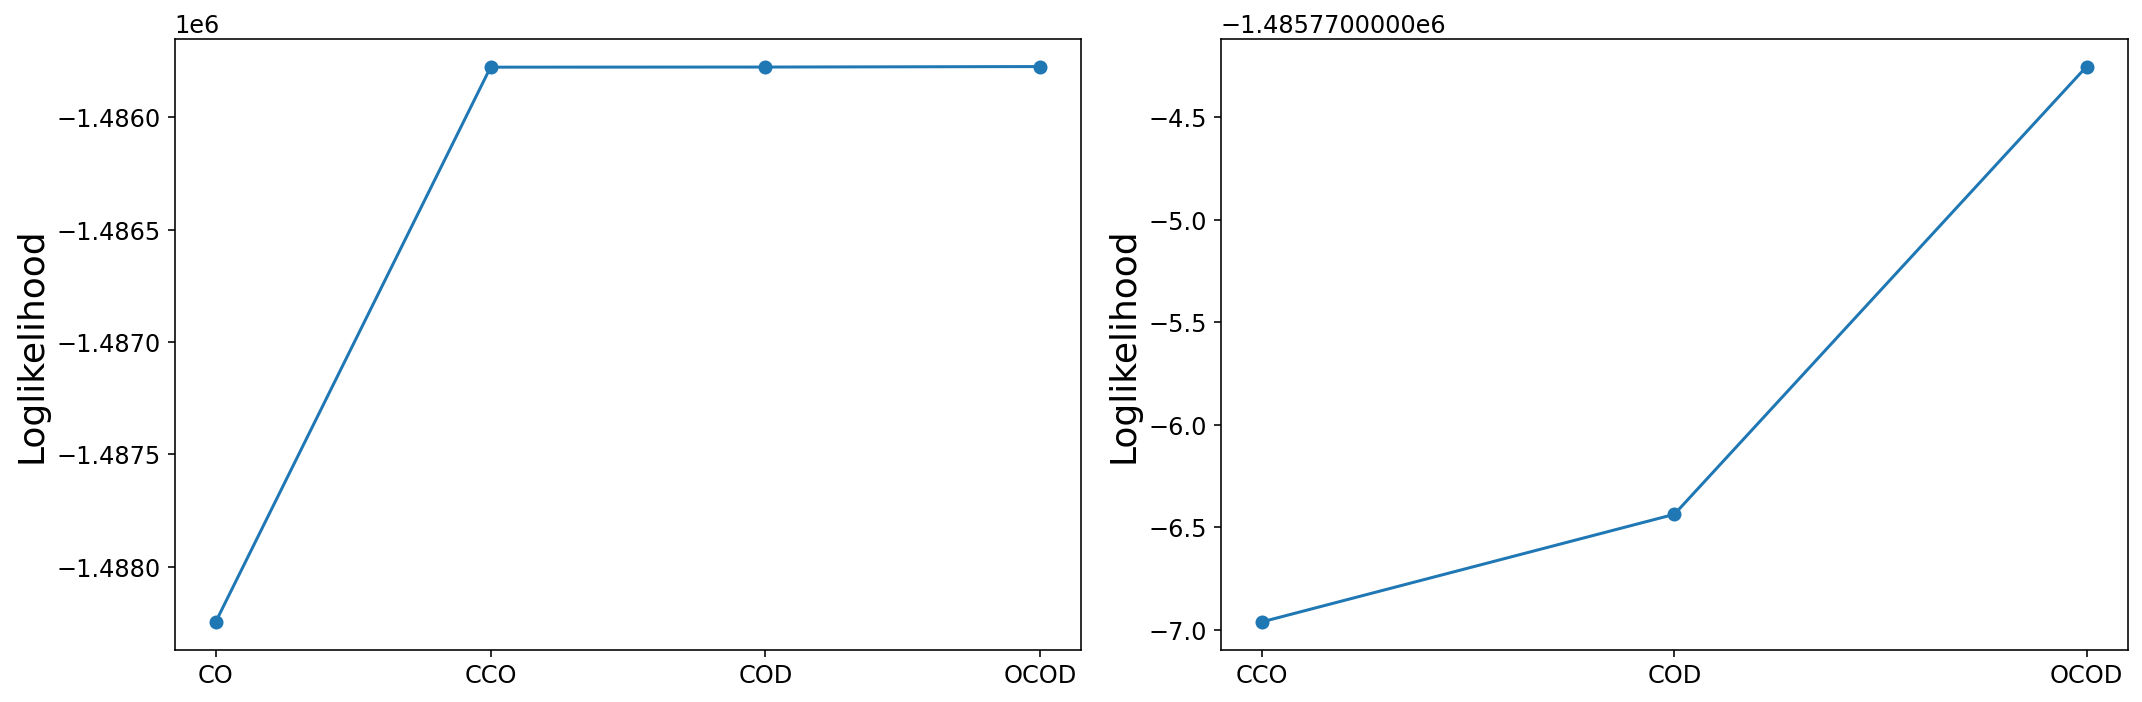

In [200]:
# LL
plt.subplot(1, 2, 1)
plt.plot(['CO', 'CCO', 'COD', 'OCOD'], [LL_CO, LL_CCO, LL_COD, LL_OCOD], 'o-')
plt.ylabel('Loglikelihood')
plt.subplot(1, 2, 2)
plt.plot(['CCO', 'COD', 'OCOD'], [LL_CCO, LL_COD, LL_OCOD], 'o-')
plt.ylabel('Loglikelihood')
plt.tight_layout();

But model OCOD has more parameters than model COD, so of course it will fit the data better.

But should we prefer it?

### Bayesian Information Criterion (BIC)

$BIC = k * ln(n) - 2 * LL$

* $k$ = # of free parameters
* $n$ = # of data points
* $LL$ = loglikelihood

In [195]:
n = len(current_pA)

BIC_CO = 6 * np.log(n) - 2 * LL_CO
BIC_CCO = 10 * np.log(n) - 2 * LL_CCO
BIC_COD = 10 * np.log(n) - 2 * LL_COD
BIC_OCOD = 14 * np.log(n) - 2 * LL_OCOD

np.array([BIC_CO, BIC_CCO, BIC_COD, BIC_OCOD]).reshape((4,1))

array([[2976574.6095077 ],
       [2971692.08023982],
       [2971691.03111571],
       [2971741.92376633]])

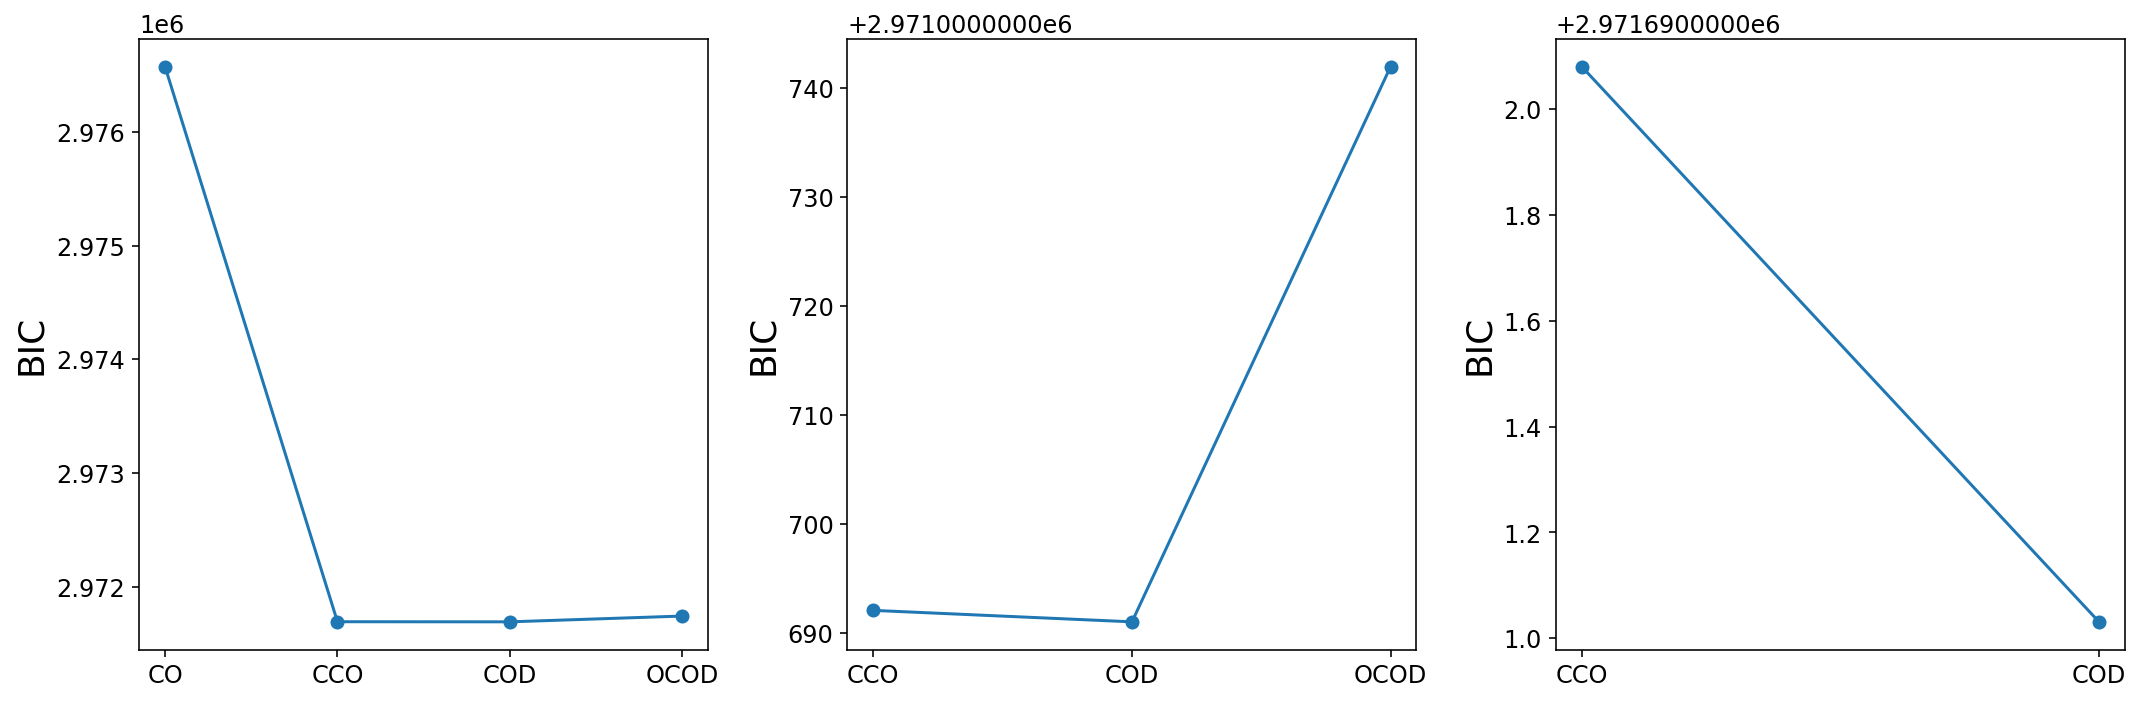

In [201]:
# BIC
plt.subplot(1, 3, 1)
plt.plot(['CO', 'CCO', 'COD', 'OCOD'], [BIC_CO, BIC_CCO, BIC_COD, BIC_OCOD], 'o-')
plt.ylabel('BIC');
plt.subplot(1, 3, 2)
plt.plot(['CCO', 'COD', 'OCOD'], [BIC_CCO, BIC_COD, BIC_OCOD], 'o-')
plt.ylabel('BIC')
plt.subplot(1, 3, 3)
plt.plot(['CCO', 'COD'], [BIC_CCO, BIC_COD], 'o-')
plt.ylabel('BIC')
plt.tight_layout();

How might you add confidence limits to each models BIC score?

i.e., how sure are we that we can tell the difference between two models based on BIC score?

# HMMs for other types of sequences (e.g., DNA)

How might you identify a gene in an unknown DNA sequence?

![](images/find-gene.png)

What about identifying the various parts (e.g., exons/introns) of a gene?

![](images/gene.png)

A very (overly) simple HMM for identifying exons and introns within a gene.

![Exon Intron HMM](images/exon-intron-gene-hmm.jpg)

 doi: 10.2174/138920209789177575

In [15]:
hmm = pom.HiddenMarkovModel()

# hidden states
exon1 = pom.State(pom.DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}), name='Exon1')
exon2 = pom.State(pom.DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}), name='Exon2')
exon3 = pom.State(pom.DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}), name='Exon3')
intron = pom.State(pom.DiscreteDistribution({'A': 0.4, 'C': 0.1, 'G': 0.1, 'T': 0.4}), name='Intron')
hmm.add_states([exon1, exon2, exon3, intron])

# transition probabilites per nucleotide
hmm.add_transition(hmm.start, exon1, 1)  # gene always starts with an exon
hmm.add_transition(exon1, exon2, 1)
hmm.add_transition(exon2, exon3, 1)
hmm.add_transition(exon3, exon1, 0.9)
hmm.add_transition(exon3, intron, 0.09)
hmm.add_transition(exon3, hmm.end, 0.01)  # gene always ends on an exon
hmm.add_transition(intron, intron, 0.9)
hmm.add_transition(intron, exon1, 0.1)

# we have to bake it before we can use it!
hmm.bake()

# post-bake order of state names
stateNames = [state.name for state in hmm.states]
stateNames

['Exon1', 'Exon2', 'Exon3', 'Intron', 'None-start', 'None-end']

What is the most likely sequence of hidden states that would give rise to the following sequence of observed nucleotides?

In [7]:
sequence = 'AAAATTGACTTATAATATTATAACAACTCTCCAGTGAGTGGATGAAACTCGGCTATGCATTGGTTGAATGGCGCTCAGAAGTTCGATGTTTGACTCCACTGCCATC'

The **Viterbi** algorithm will find the most likely state sequence for a given observation sequence.

In [8]:
# most likely state sequence giving rise to the observed nucleotide sequence
states = hmm.predict(list(sequence))

print(sequence)
print(''.join([str(s) for s in states]))

AAAATTGACTTATAATATTATAACAACTCTCCAGTGAGTGGATGAAACTCGGCTATGCATTGGTTGAATGGCGCTCAGAAGTTCGATGTTTGACTCCACTGCCATC
0120120123333333333333333012012012012012012012012012012012012012012012012012012012012012012012012012012012


In [9]:
print(sequence)
print(''.join(['e' if s < 3 else 'i' for s in states]))

AAAATTGACTTATAATATTATAACAACTCTCCAGTGAGTGGATGAAACTCGGCTATGCATTGGTTGAATGGCGCTCAGAAGTTCGATGTTTGACTCCACTGCCATC
eeeeeeeeeiiiiiiiiiiiiiiiieeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


# Exercise

Use the above model to identify the exon and introns in the following sequence `seq`.

In [11]:
seq = 'TCCACCTGAGGGTAAAGAACCGTCTGCACTAGGTTATTCACATTGGATGCATTTGAAGATCAAATAAGTTCTAATCCG'

# Exercise

Optimize the above model based soley on the sequence `seq` above.

Often, you want to optimize a model based on multiple sequences.

In [12]:
# optimize the model parameters based on the two sequences 'sequence' and 'seq' above.
hmm.fit([list(sequence), list(seq)]);

In [13]:
def printModelParams(hmm):
    A = hmm.dense_transition_matrix()
    Af = pd.DataFrame(A, index=stateNames, columns=stateNames)
    Bf = pd.DataFrame([list(state.distribution.parameters[0].values()) for state in hmm.states[:-2]], 
             index=stateNames[:-2], columns=['A', 'C', 'G', 'T'])
    states = stateNames[:-2]
    print('Transition probabilities:')
    print('-------------------------')
    print(Af)
    print()
    print('Emission distribution parameters:')
    print('---------------------------------')
    for i in range(len(hmm.states) - 2):
        A = hmm.states[i].distribution.parameters[0]["A"]
        T = hmm.states[i].distribution.parameters[0]["T"]
        C = hmm.states[i].distribution.parameters[0]["C"]
        G = hmm.states[i].distribution.parameters[0]["G"]
        print(f'{hmm.states[i].name}: A={A:.3f}, T={T:.3f}, C={C:.3f}, G={G:.3f}')

In [14]:
# optimized model parameters
printModelParams(hmm)

Transition probabilities:
-------------------------
               Exon1  Exon2  Exon3    Intron  None-start  None-end
Exon1       0.000000    1.0    0.0  0.000000         0.0  0.000000
Exon2       0.000000    0.0    1.0  0.000000         0.0  0.000000
Exon3       0.856874    0.0    0.0  0.104294         0.0  0.038832
Intron      0.182156    0.0    0.0  0.817844         0.0  0.000000
None-start  1.000000    0.0    0.0  0.000000         0.0  0.000000
None-end    0.000000    0.0    0.0  0.000000         0.0  0.000000

Emission distribution parameters:
---------------------------------
Exon1: A=0.416, T=0.312, C=0.067, G=0.206
Exon2: A=0.143, T=0.239, C=0.282, G=0.336
Exon3: A=0.265, T=0.248, C=0.290, G=0.196
Intron: A=0.427, T=0.436, C=0.137, G=0.000


### !!! HMMs widely aplicable to understanding sequences.